# K-Means Clustering Implementation

Today we will look at the implementation of kmeans. An outline:

1. Data simulation
2. kmeans implementation
3. Some extensions: k means ++
4. Using plots to examine kmeans as it progresses

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans # for comparison

Make some simulated data; we will create simple random uniform blobs here. Try playing with the groups parameter to see what the function is doing.

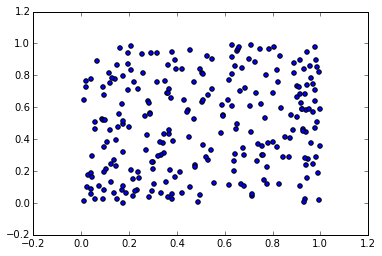

In [14]:
# Make some simple data on the unit square
def MakeUnifData(N, groups=2):
    XX = np.random.rand(N, 2)
    
    for ii in range(1, groups):
        XX = np.vstack((XX, np.random.rand(N, 2) + ii))
    
    return(XX)

X = MakeUnifData(250, 1)
plt.scatter(X[:, 0], X[:, 1])

Plots are a nice way to see how the algorithm works and progresses. This adds a plotting step to each iteration of the implementation.

Also, it is nice to be able to turn this behavior off and on, so we have added an additional "plotting" argument to the function (a boolean) that will trigger this behavior.

In [3]:
def PlottingStep(ax, X, centers, cluster_assign, ii):
    ax[ii].scatter(X[:, 0], X[:, 1], c=cluster_assign, s=100)
    
    # mark the current centers specially
    ax[ii].scatter(centers[:, 0], centers[:, 1], c='gold', s=100)

Let's implement K means, which has the following steps:

1. Pick some starting points
2. Iterate the following until we get no updating of cluster assignments:

a. Assign points to nearest cluster centroid

b. Calculate centroids of each cluster

In [4]:
# first, we define some helped functions

def Init(X, k):
    # initialize k-mean centers
    
    # randomly select some centers from the data
    selections = np.random.choice(X.shape[0], k, replace=False)
    
    return X[selections, :]
    
def AssignPointToNearestCluster(x, centers, k):
    # assign a point to the nearest cluster center
    # IMPLEMENT THIS
    
    # the distance of this point to the nearest center
    # note: we could change the distance here; remember the kernel trick?
    dists = np.array([np.sum((x - cc) ** 2) for cc in centers])
    closest_center = np.where(dists == np.min(dists))
    return closest_center

def AssignPointsToNearestClusters(X, centers, k):
    # a wrapper to AssignPointToNearestCluster which does that
    # for all the points in a data set X
    
    return np.array([AssignPointToNearestCluster(X[ii, :], centers, k) for ii in range(X.shape[0])]).flatten()

def CalculateCenters(X, cluster_assign, k):
    # update cluster centers: this will be the mean value on each
    # feature within each group of Xs assigned to each cluster
    
    # IMPLEMENT THIS
    centers = []
    
    for kk in range(k):
        centers.append(np.mean(X[cluster_assign == kk, :], 0))
    
    return np.array(centers)

def MyKmeans(X, k, max_iter=10, plotting=True, verbose=False, retscore=True):
    # k means implementation
    # initialize some way...
    
    # centers = KmeansPlusPlusInit(X, k)
    centers = Init(X, k)
    
    cluster_assign = AssignPointsToNearestClusters(X, centers, k)

    if plotting:
        f, ax = plt.subplots(max_iter + 1)

    for ii in range(max_iter):
        if plotting:
            PlottingStep(ax, X, centers, cluster_assign, ii)
            ax[ii].scatter(X[:, 0], X[:, 1], c=cluster_assign, s=100)
            ax[ii].scatter(centers[:, 0], centers[:, 1], c='gold', s=100)
            
        # assign points
        cluster_assign = AssignPointsToNearestClusters(X, centers, k)
    
        # update centers
        previous_centers = centers
    
        centers = CalculateCenters(X, cluster_assign, k)
    
        # check if update is the same as the last iteration
        if verbose:
            print ii, ClusterScore(X, cluster_assign)

    if plotting:
        PlottingStep(ax, X, centers, cluster_assign, max_iter) # plot the last iter
        f.set_figheight(max_iter * 3)
        f.set_figwidth(3)
        
    if retscore:
        return ClusterScore(X, cluster_assign)
    else:    
        return centers
    return False


One way to monitor k means is to calculate a score at each step.
The most popular scoring of k means is the ratio of the between sum of squares to the within sum of squares. These are the sums of the squared differences between pairs of points in different clusters (for between) and in the same cluster (for within). 

Intuitively, this measures how tight each cluster is in relation to how separated they all are.

Try implementing this measure and plot it or print it out over many iterations of your implementation.

In [5]:
def ClusterScore(X, cluster_assign):
    # between SS / (between SS + within SS)
    between = 0.0
    within = 0.0
    
    for ii in range(X.shape[0]):
        for jj in range(ii, X.shape[0]):
            ss = np.sum((X[ii, :] - X[jj, :]) ** 2)
            if cluster_assign[ii] == cluster_assign[jj]:
                within += ss
            else: 
                between += ss
    
    return between / (between + within)

Try implementing the kmeans ++ intialization step. Here, we pick points
for our inital clusters by picking already well separated points. We do this as follows:

1. Pick the first point (center) randomly
2. For each point calculate the nearest distance to any of the other centers.
3. Select the next point (center) from the remaining points from a distribution with probabilities proportaional to that point's disatnce to nearest center.

In [6]:
def KmeansPlusPlusInit(X, k):
    # initialize k-mean centers with KM++ initialization
    # what is this doing?
    
    # base case when k = 1
    if k == 1:
        selections = np.random.choice(X.shape[0], k, replace=False)
    else:
        selections = []
        
        # pick the first one randomly
        selections.append(np.random.choice(X.shape[0], 1, replace=False))
        
        for ii in range(1, k):
            dists_to_closest_center = []
            
            for jj in range(X.shape[0]):
                # IMPLEMENT THIS: find the smallest distance to each cluster center
                dists = [np.sum((X[jj, :] - X[cc, :]) ** 2) for cc in selections]
                
                min_dist = np.min(np.array(dists))
                
                dists_to_closest_center.append(min_dist)
                
            select_probs = np.array(dists_to_closest_center)
            select_probs /= np.sum(select_probs)
            
            selections.append(np.random.choice(X.shape[0], 1, p=select_probs))
            
        selections = np.array(selections).flatten()
    
    return X[selections, :]

0.94483987069843245

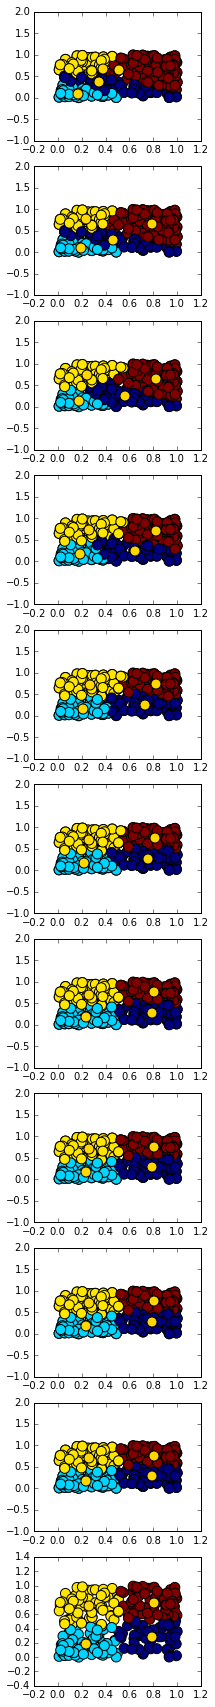

In [15]:
MyKmeans(X, 4, plotting=True)

Let's try to pick K with our scoring criteria. Modify the kmeans function to return the final score. Then compute k means for k=[1, ..., 10] and plot the final score found in each round.

What is the problem with this score? Can we use it to pick k?

In [8]:
scores = []

for kk in range(2, 10):
    scores.append(MyKmeans(X, kk, plotting=False))


[0.87859537662938825, 0.95065127437323294, 0.97230371411748284, 0.98696693596170171, 0.9903593556275716, 0.99264202076887709, 0.99218000308224108, 0.99560026029565107]


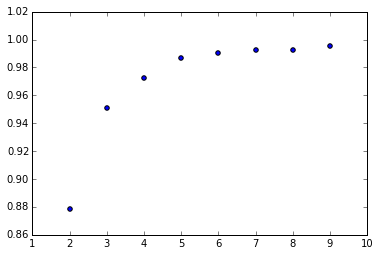

In [9]:
print scores
plt.scatter(range(2, 10), scores)

Sometimes k means is not very stable, and will return different results for different starting conditions. Using the trickier dataset below, try running kmeans with k = 2 and examine the stability of the clustering results. We can check the stability by looking at the plots, or by looking at the final estimated centers.

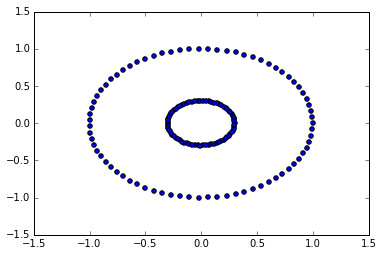

In [10]:
# Make some otherwise simple data on the unit square
from sklearn.datasets import make_circles

X2, y = make_circles(n_samples=150, factor=.3, noise=0.00000001)

plt.scatter(X2[:, 0], X2[:, 1])


0.6570283958808284

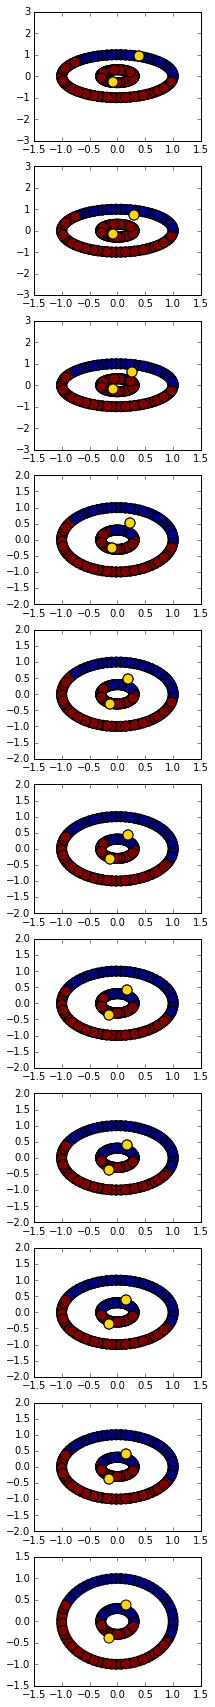

In [11]:
MyKmeans(X2, 2, plotting=True)

In [12]:
# check for clustering stability

criteria_list = []

for rr in range(10):
    print MyKmeans(X2, 2, plotting=False, retscore=False)
    
    #criteria_list.append(MyKmeans(X2, 2, plotting=False, retscore=False))
    
#print criteria_list

#plt.scatter(range(10), criteria_list)

[[ 0.39609548  0.13793504]
 [-0.38567191 -0.13430517]]
[[ 0.12960959  0.3988973 ]
 [-0.12619881 -0.38840001]]
[[-0.0438419   0.41712779]
 [ 0.04268816 -0.40615074]]
[[-0.23937179 -0.34441087]
 [ 0.23307254  0.33534743]]
[[ 0.07652427  0.40115426]
 [-0.07859249 -0.41199627]]
[[-0.41778525 -0.03508241]
 [ 0.4067909   0.03415919]]
[[ 0.06127094  0.41492599]
 [-0.05965855 -0.40400689]]
[[-0.02564289 -0.40758208]
 [ 0.02633594  0.41859781]]
[[ 0.00855263  0.40829837]
 [-0.00878378 -0.41933346]]
[[-0.41611815 -0.05256795]
 [ 0.40516767  0.05118458]]
